# (ii.) Here we try using the upper and lower bounds for all interpolated values for predictions and inflated prediction intervals.

## In this notebook: Gurkor-Water (but you can exchange the indices for the other time series as well, see comments)

In [73]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(readr)
library(hrbrthemes)
library(patchwork)
library(zoo)
library(forecast)
library(Metrics)
library(tseries)
library(tibble)
library(rugarch) 

In [74]:
# load data
data<-read.csv("/kaggle/input/spiff-data/spiff_data.csv", header=TRUE)

In [75]:
# just as in the data cleaning we replace the outliers with values > 100 by Nan
#replacing outliers by linear interpolation
data[c(36,1194,2836,3430,4118),-c(1,2)] <- NA
for (i in c(36,1194,2836,3430,4118)) {
  data[c(i-1,i,i+1),] <- na.approx(data[c(i-1,i,i+1),])   
}

In [76]:
ndiffs(data[,3]) # gurkor recommneded differentiations is 1 (same for all other time series as well..)
ndiffs(data[,4])
ndiffs(data[,5])
ndiffs(data[,6])
ndiffs(data[,7])
ndiffs(data[,8])
ndiffs(data[,9])

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

[1] 1

In [77]:
# Compute log-returns for a more stationary time series
data_lr <- data %>%
  arrange(day) %>%  # Ensure the data is ordered by date
  mutate(across(-c(X, day), ~ log(. / lag(.)), .names = "log_return_{.col}"))

In [149]:
#data_lr

### We'll look at both Gurkor and Water toghether since they are correalted time series in the data.

In [79]:
gurkor_lr <- data_lr[,10]    #
water_lr <- data_lr[,15] # 

#which(is.na(gurkor_lr))   

In [80]:
#which(is.na(water_lr))    #Looking for missing values in water

1. Split into train/test/eval for the model fitting and evaluation of the best model approach

In [83]:
# Total length of the series
n_total <- length(gurkor_lr)

# Length of forecast horizon (NA block at the end)
h <- 200

# Determine start of NA block
na_start <- n_total - h + 1

# Test set is 200 points before the NA block
test_indices <- (na_start - h):(na_start - 1)

# Training set is everything before the test set
train_indices <- 1:(na_start - h - 1)

# Split for gurkor
gurkor_train <- gurkor_lr[train_indices]
gurkor_test <- gurkor_lr[test_indices]

# Split for water
water_train <- water_lr[train_indices]
water_test <- water_lr[test_indices]


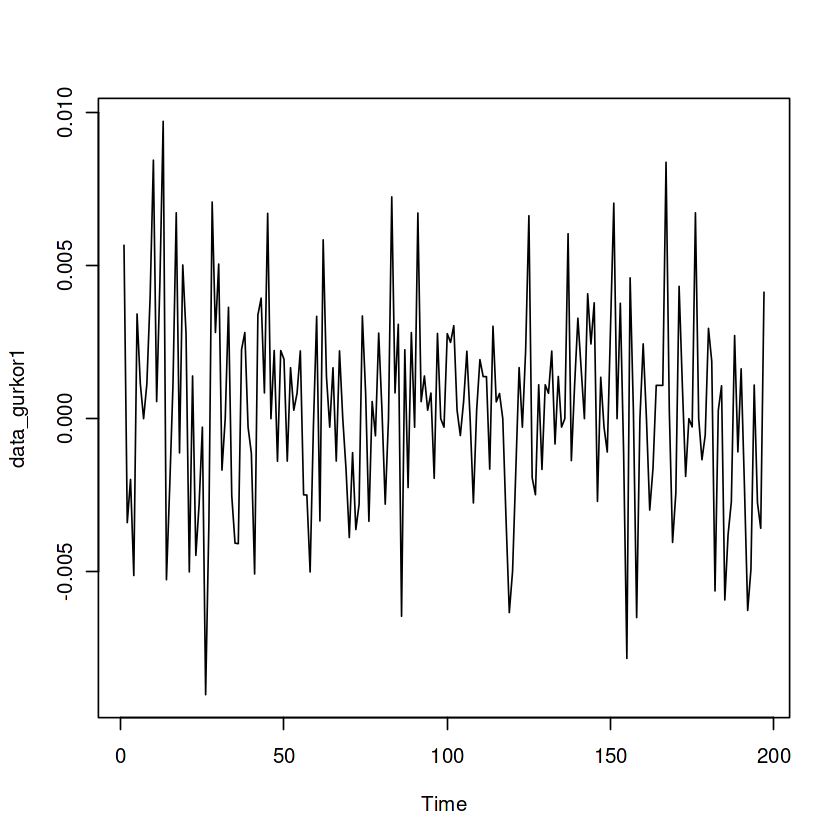

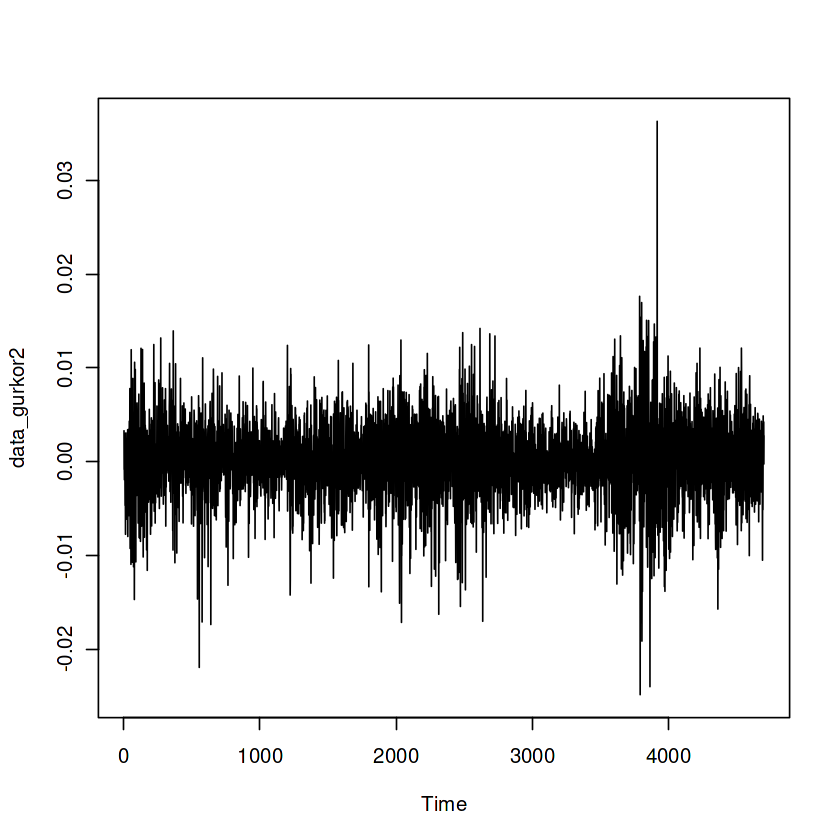

In [150]:
data_gurkor1 <- gurkor_train[2:198]   #Creating object consisting of values before the NA gap at the beginning of the t.s.
data_gurkor2 <- gurkor_train[250:4953]   #Creating object consisting of values after the NA gap at the endo of the t.s. (not including the last 200 points that will be used for the testing set).

# for slingshots :
#data_slingshots1 <- slingshots_lr[2:598]  
#data_slingshots2 <- slingshots_lr[650:4953]   

# for guitars: 
#data_guitars1 <- guitars_lr[2:398]  
#data_guitars2 <- guitars_lr[450:4953]   

# for sugar:
#data_sugar1 <- sugar_lr[2:998]  
#data_sugar2 <- sugar_lr[1050:4953]   

# For stocks:
#data_stocks1 <- stocks_lr[2:798]   
#data_stocks2 <- stocks_lr[850:4953]   

# for tranquility:
#data_tranquility1 <- stocks_lr[2:1398]   
#data_tranquility2 <- stocks_lr[1450:4953]  

plot.ts(data_gurkor1)   
plot.ts(data_gurkor2)

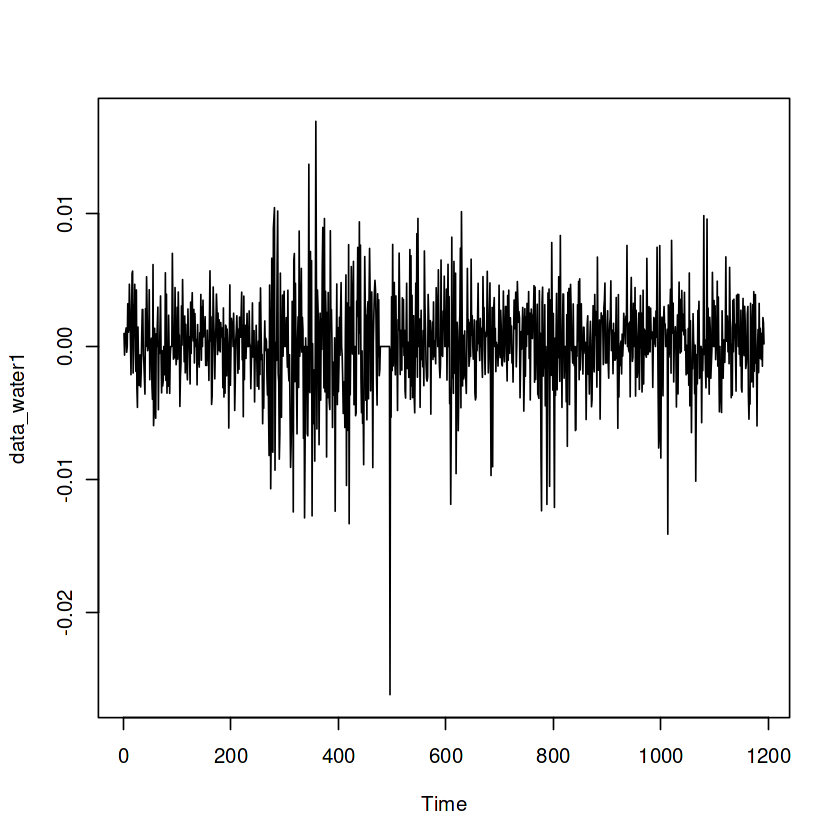

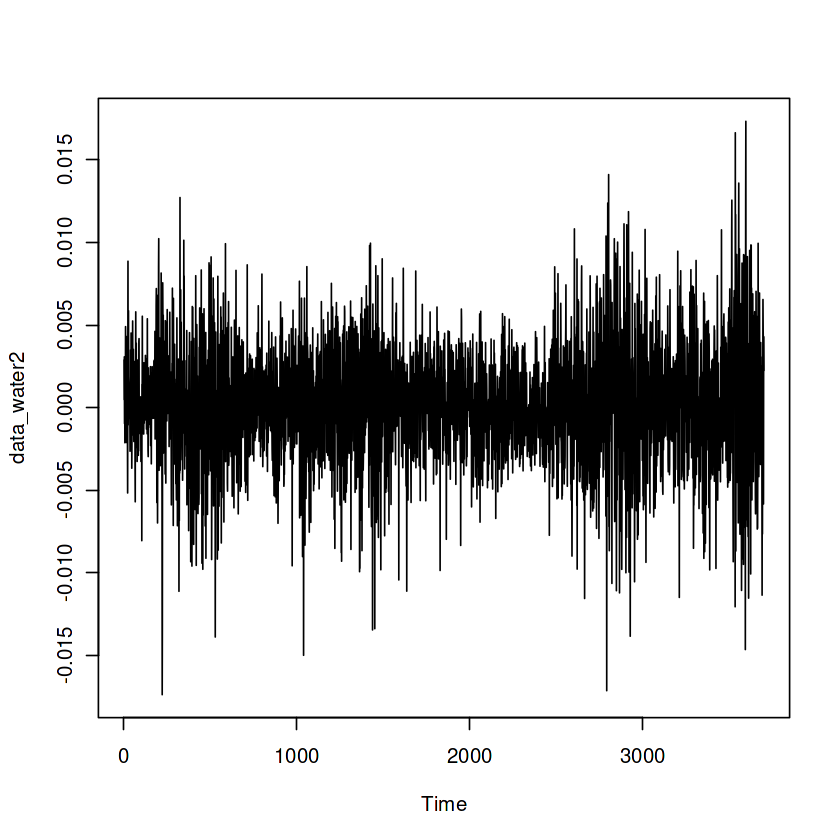

In [151]:
data_water1 <- water_train[2:1193]  #Creating object consisting of values before the NA gap at the beginning of the t.s.
data_water2 <- water_train[1250:4953]   #Creating object consisting of values after the NA gap at the endo of the t.s (not including the last 200 points that will be used for the testing set).

plot.ts(data_water1)   
plot.ts(data_water2)

In [84]:
length(gurkor_test)

[1] 200

## Applying Monte Carlo Simulation

- we have interpolated training points, each with a 95% confidence interval.

- we also have a 200-point test set.

In [85]:
# our interpolated means and upper and lower 95% CI bounds

mean_vals <- read_csv("/kaggle/input/interpolated/all_series_stl_imputed.csv", col_names = TRUE,show_col_types = FALSE)
lower_vals <- read_csv("/kaggle/input/interpolated/all_series_ci_lower.csv", col_names = TRUE,show_col_types = FALSE)
upper_vals <- read_csv("/kaggle/input/interpolated/all_series_ci_upper.csv", col_names = TRUE,show_col_types = FALSE)

mean_vals_tran <- mean_vals %>%
  arrange(day) %>%
  mutate(across(-day, ~ log(. / lag(.)), .names = "log_return_{.col}"))

lower_vals_tran <- lower_vals %>%
  arrange(day) %>%
  mutate(across(-day, ~ log(. / lag(.)), .names = "log_return_{.col}"))

upper_vals_tran <- upper_vals %>%
  arrange(day) %>%
  mutate(across(-day, ~ log(. / lag(.)), .names = "log_return_{.col}"))


In [152]:
#mean_vals_tran

In [87]:
# we look at gurkor now:
upper_vals_gurkor <- upper_vals_tran[9] # # 10 for guitars, 11 for slingshots, 12 for stocks, 13 for sugar, 14 for water, 15 for tranquility
lower_vals_gurkor <- lower_vals_tran[9]
mean_vals_gurkor <- mean_vals_tran[9]

# only looking at the interpolated 
upper_vals_gurkor <- upper_vals_gurkor[198:248, ] #  # 398:448 for guitars, 598:648 for slingshots, 798:848 for stocks, 998:1048 for sugar,  1398:1448 for tranquility
lower_vals_gurkor <- lower_vals_gurkor[198:248, ]
mean_vals_gurkor <- mean_vals_gurkor[198:248, ]

# Calculate standard deviation from 95% confidence intervals
sigma_vals_gurkor <- (upper_vals_gurkor - lower_vals_gurkor) / (2 * 1.96)

upper_vals_gurkor_original <- upper_vals[2] # 3 for guitars, 4 for slingshots, 5 for stocks, 6 for sugar, 7 for water, 8 for tranquility
lower_vals_gurkor_original <- lower_vals[2]
mean_vals_gurkor_original <- mean_vals[2]

upper_vals_gurkor_original <- upper_vals_gurkor_original[197:248, ] # # 397:448 for guitars, 597:648 for slingshots, 797:848 for stocks, 997:1048 for sugar,  1397:1448 for tranquility
lower_vals_gurkor_original <- lower_vals_gurkor_original[197:248, ]
mean_vals_gurkor_original <- mean_vals_gurkor_original[197:248, ]

# Calculate standard deviation from 95% confidence intervals
sigma_vals_gurkor_original <- (upper_vals_gurkor_original - lower_vals_gurkor_original) / (2 * 1.96)


### Simulate Sets
- Generate N=1000 simulated versions of the training set by sampling each interpolated value from its estimated distribution (Normal).

- Each of these is a plausible realisation of the data.

In [88]:

mean_vec <- as.numeric(mean_vals_gurkor_original[[1]])
sigma_vec <- as.numeric(sigma_vals_gurkor_original[[1]])
sigma_vec <- abs(sigma_vec)


# Number of simulations and data points
n_sim <- 1000
n_points <- length(mean_vec)

simulated_series <- matrix(NA, nrow = n_sim, ncol = n_points)

for (i in 1:n_sim) {
  simulated_series[i, ] <- rnorm(n_points, mean = mean_vec, sd = sigma_vec)
}

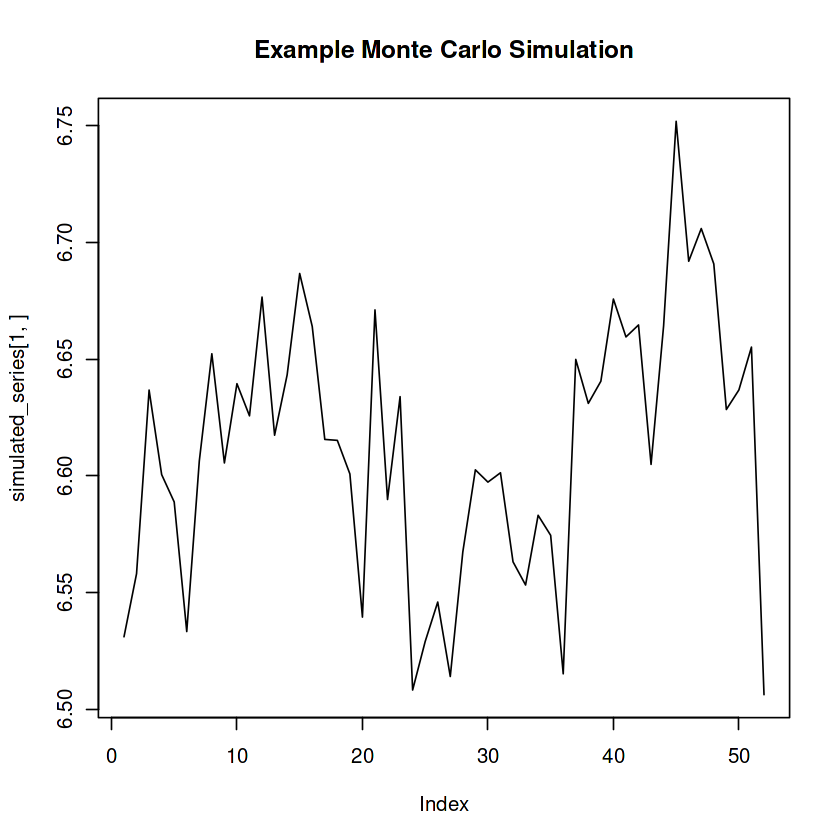

In [89]:
plot(simulated_series[1, ], type = "l", main = "Example Monte Carlo Simulation")


In [90]:
pdf("simulated_series_plot.pdf", width = 8, height = 6)

plot <- matplot(t(simulated_series[1:20, ]), type = "l", lty = 1, col = rainbow(20), 
        main = "First 20 Simulated Series")

dev.off()


png 
  2

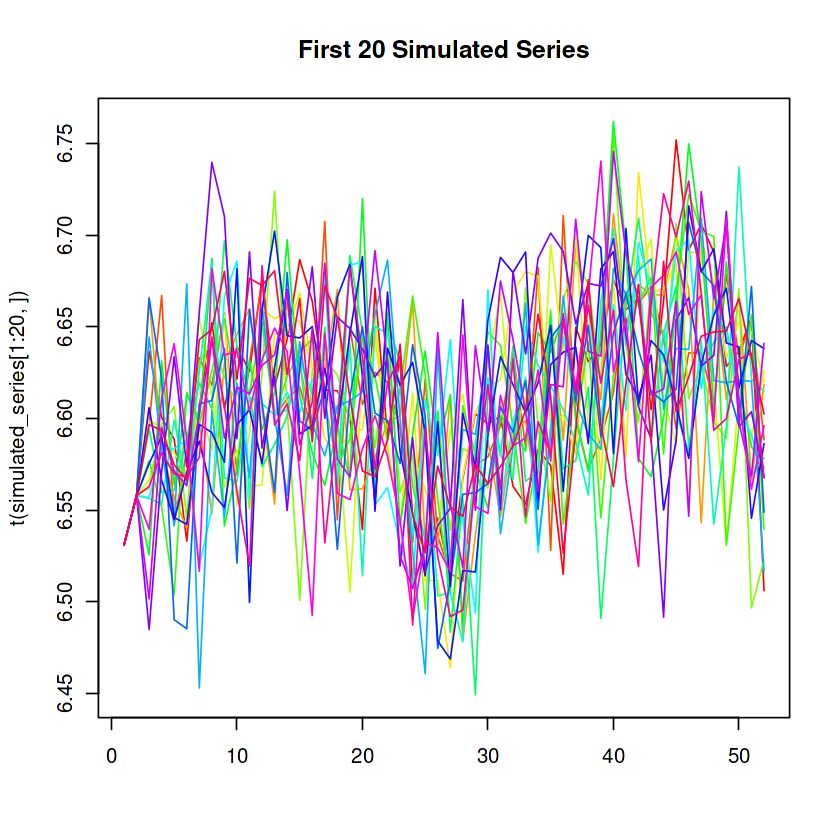

In [91]:
plot<-matplot(t(simulated_series[1:20, ]), type = "l", lty = 1, col = rainbow(20), 
        main = "First 20 Simulated Series")


In [92]:
# transform to log-returns 
log_return_simulated <- log(simulated_series[, -1] / simulated_series[, -ncol(simulated_series)])


### Fit Models on Simulated Training Sets
For each simulated training set:

- Fit ARMA, GARCH (and ARIMAX if it has a correlated series to utilize for exogenous input) 

- Forecast 200 points (matching the test set).

Store the forecasts for each model across all simulations.

# ARMA and GARCH models for the time series modeling

## ARMA models for Gurkor:

#### Look at the ACF and PACF for what param. values for q and p to try out during the model fittings

In [93]:
# create pdf
pdf("acf_plots.pdf", width = 8, height = 6)
par(mfrow = c(2, 2))  
# First ACF plot
acf(data_gurkor1, main = "ACF of Gurkor before NA gap")

# Second ACF plot 
acf(data_gurkor2, main = "ACF of Gurkor after NA gap")

pacf(data_gurkor1, main = "PACF of Gurkor before NA gap")     
pacf(data_gurkor2, main = "PACF of Gurkor after NA gap")

dev.off()

png 
  2

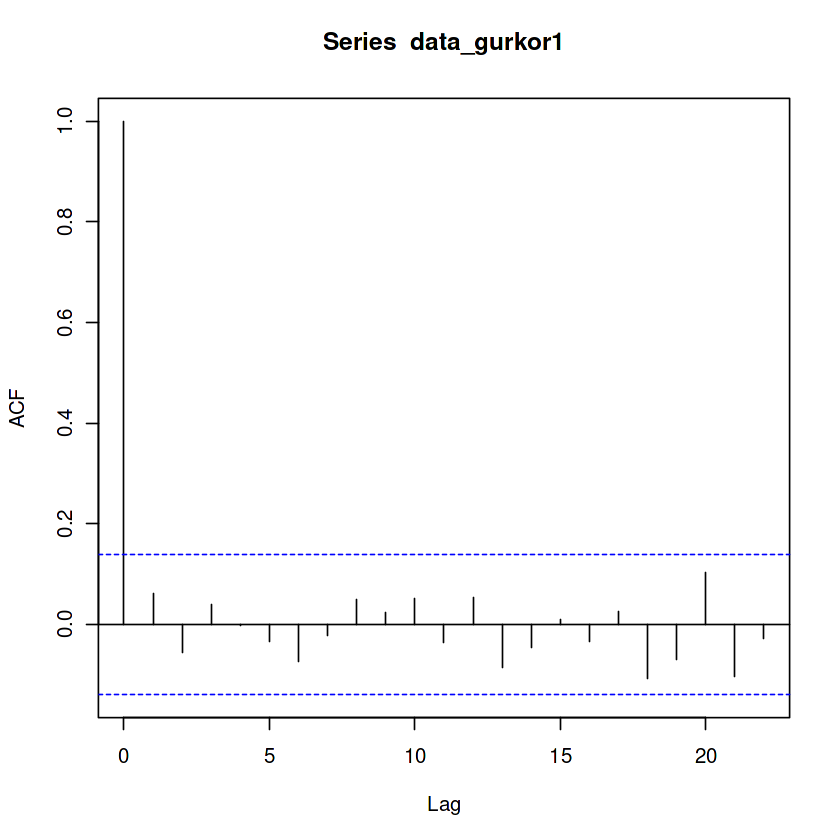

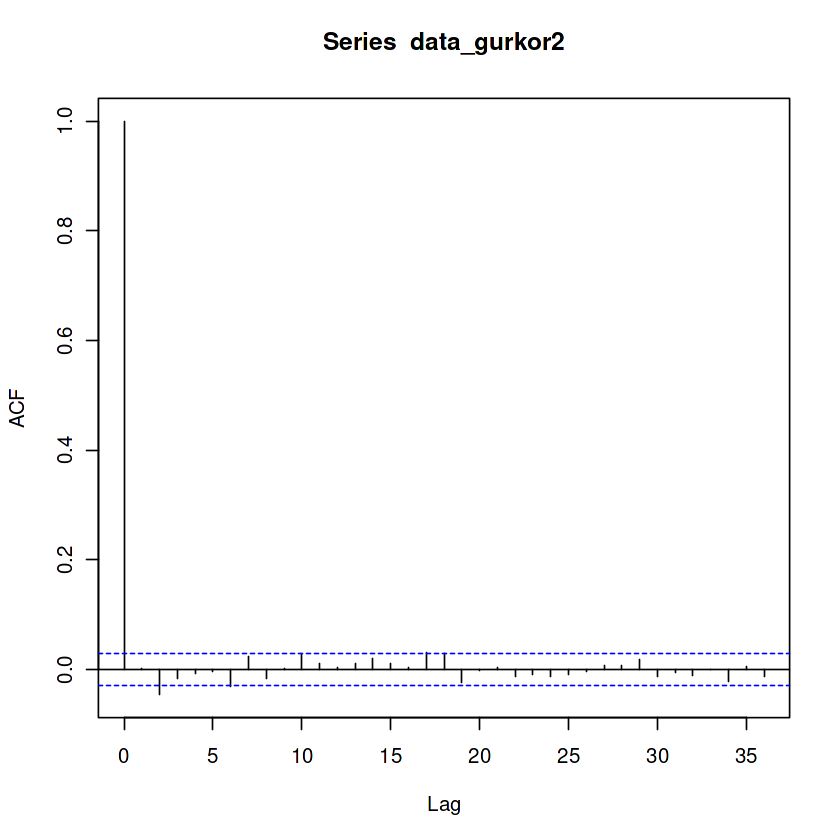

In [94]:
# ACF for gurkor (looking at the time series training data before and after the nan gap separately)
acf(data_gurkor1)  
acf(data_gurkor2)

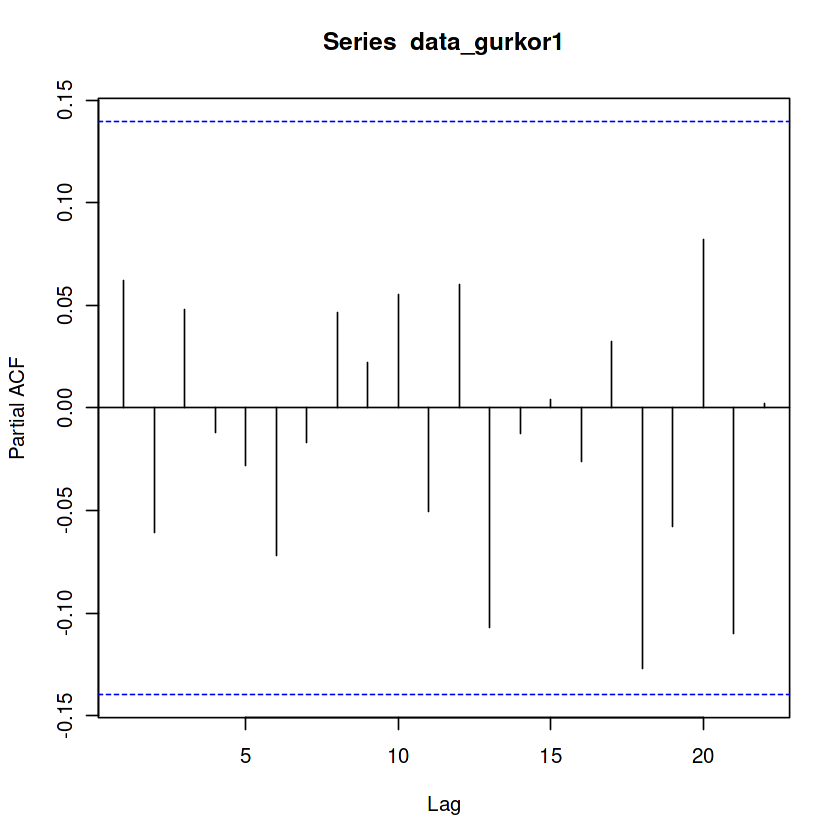

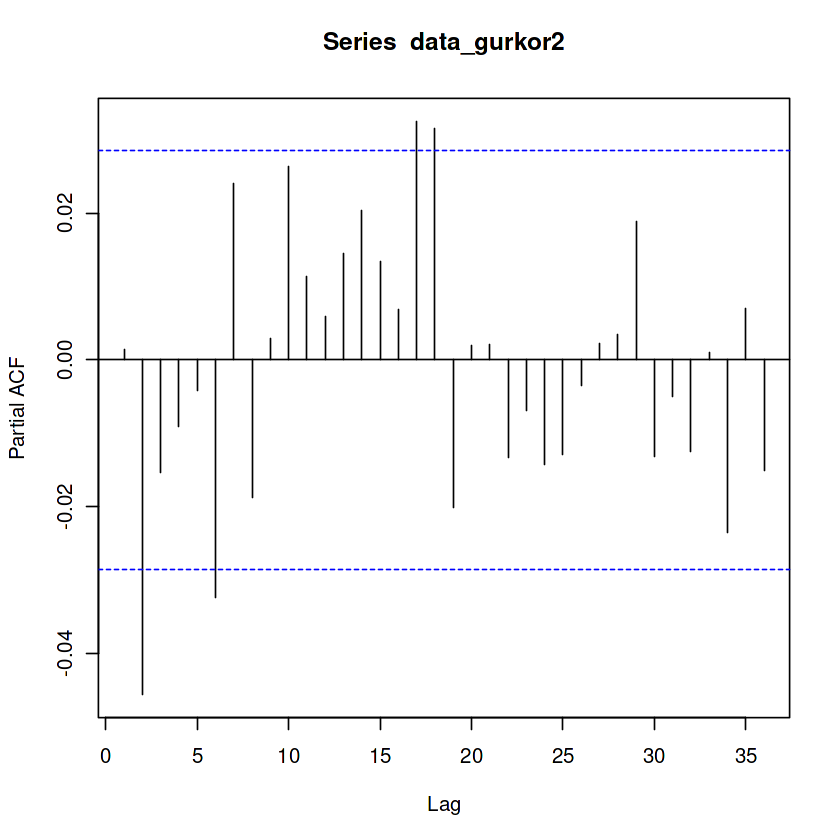

In [95]:
# PACF for gurkor (looking at the time series training data before and after the nan gap separately)
pacf(data_gurkor1)     #Looking at pacf
pacf(data_gurkor2)

#### gurkor ACF & PACF gives:
- q={0,1,2,3}, (there is a significant spike at 0 in the ACFs but on one occasion a small one at 3 as well so we'll check a few out.)
- p={0} (The PACF seems to be exponnetially decaying and or sinusoidal so we set p=0 )
- d=0 (since we already differentiated by taking the log-returns of the time series)

#### 3. Train/fit the models on the training data

In [96]:

n_sim <- nrow(simulated_series)
h <- 200  # forecast length
gap_indices <- 198:248  # indices of the interpolated segment, # 398:448 for guitars, 598:648 for slingshots, 798:848 for stocks, 998:1048 for sugar,  1398:1448 for tranquility
# candidate orders based on ACF/PACF plots
candidate_orders <- list( # excahnge here for candidate orders for each time series
  c(0, 0),
  c(0, 1),
  c(0, 2),
  c(0, 3)
)


In [97]:

results <- tibble(
  p = integer(),
  q = integer(),
  AIC = numeric(),
  BIC = numeric(),
  LjungBox_pval = numeric()
)

full_series <- as.numeric(gurkor_train[-1])  
sim_series <- log_return_simulated  

# Loop through models
for (order in candidate_orders) {
  p <- order[1]
  q <- order[2]

  for (i in 1:n_sim) {
      # Create a copy of the full training set
      train_copy <- full_series
      #  Replace the interpolated gap with simulated values
      train_copy[gap_indices] <- sim_series[i, ]
       #  Convert to time series
      train_ts <- ts(train_copy)
      # Fit ARMA model (ARIMA with d = 0)
      fit <- Arima(train_ts, order = c(p, 0, q))
        # Residual check
      lb_test <- Box.test(residuals(fit), lag = 10, type = "Ljung-Box")
  
      # Store results
      results <- add_row(results, 
                     p = p,
                     q = q,
                     AIC = AIC(fit),
                     BIC = BIC(fit),
                     LjungBox_pval = lb_test$p.value)
     }
}


In [98]:


summary_results <- results %>%
  group_by(p, q) %>%
  summarise(
    avg_AIC = mean(AIC, na.rm = TRUE),
    avg_BIC = mean(BIC, na.rm = TRUE),
    avg_LB = mean(LjungBox_pval, na.rm = TRUE),
    prop_good_LB = mean(LjungBox_pval > 0.05, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(prop_good_LB), avg_AIC, avg_BIC)


In [99]:
summary_results

p,q,avg_AIC,avg_BIC,avg_LB,prop_good_LB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,-41230.72,-41198.08,0.225581786,0.773
0,2,-41231.03,-41204.92,0.167943543,0.694
0,1,-41223.35,-41203.77,0.018755845,0.097
0,0,-41220.89,-41207.83,0.004721117,0.002


### Forecast 200 points for the evaluation against the test set:

In [100]:
n_sim <- nrow(sim_series)
h <- 200
gap_indices <- 198:248 # 398:448 for guitars, 598:648 for slingshots, 798:848 for stocks, 998:1048 for sugar,  1398:1448 for tranquility
#  list for forecasts
ARMA_gurkor_forecasts <- matrix(NA, nrow = n_sim, ncol = h)

for (i in 1:n_sim) {
  # Create copies of the data
  gurkor_copy <- as.numeric(gurkor_train[-1]) # first point is NA so we exclude it
  
  #Replace gaps with simulations
  gurkor_copy[gap_indices] <- sim_series[i, ]
  
  # Fit ARIMA to water and forecast 200 ahead
  gurkor_fit <- Arima(gurkor_copy, order = c(0, 0, 2)) # exchange here for the best model found in the previous step for each time series

  
  # Forecast 200 
  gurkor_fc <- forecast(gurkor_fit, h = h)
  
  # Store forecasts
  ARMA_gurkor_forecasts[i, ] <- gurkor_fc$mean
}


## GARCH model for Gurkor:

[1] 5004

[1] 5055

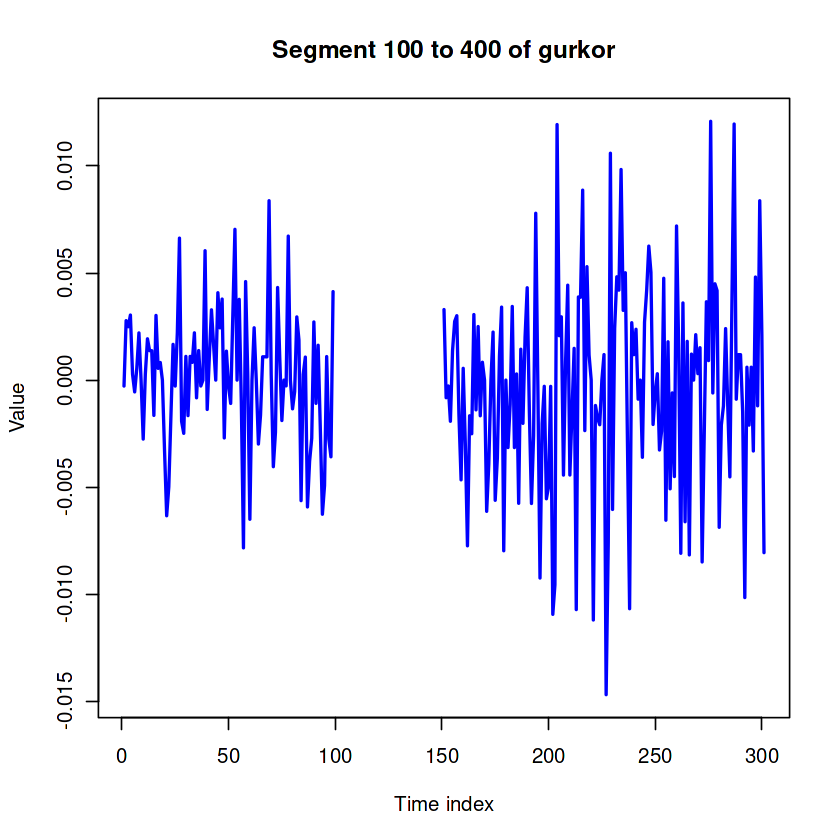

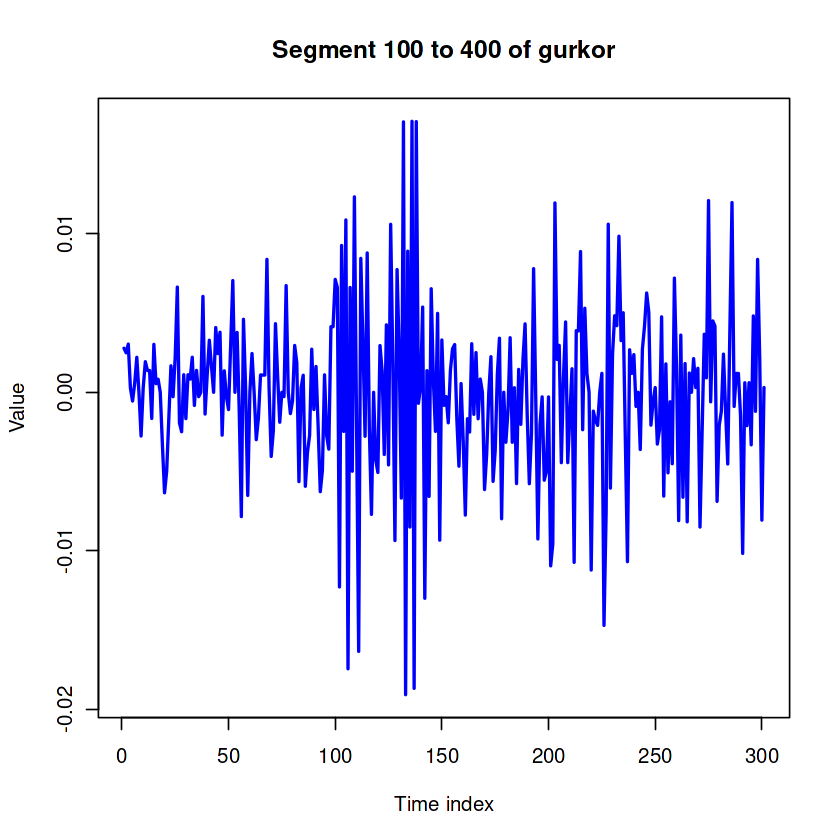

In [153]:
# looking at a realisation of the training data, the difference between the observed points and the simulation makes eGARCH a better option then sGARCH for us.
series <- as.numeric(gurkor_train[-1])
length(na.omit(series))
series[gap_indices] <- as.numeric(log_return_simulated[i, ])
ts_series <- ts(na.omit(series))
length(na.omit(series))
plot_segment <- function(series, a, b, main_title = NULL) {
  # Check if indices are valid
  if (a < 1 || b > length(series) || a >= b) {
    stop("Invalid indices for the segment")
  }
  
  segment <- series[a:b]
  plot(segment, type = "l", col = "blue", lwd = 2,
       xlab = "Time index", ylab = "Value",
       main = ifelse(is.null(main_title), paste("Time Series Segment:", a, "to", b), main_title))
}

plot_segment(gurkor_train, 100, 400, main_title = "Segment 100 to 400 of gurkor")
plot_segment(ts_series, 100, 400, main_title = "Segment 100 to 400 of gurkor")


In [102]:

results_garch <- tibble(
  model = character(),
  AIC = numeric(),
  BIC = numeric()
)

garch_orders <- list( c(1,1)) # the vanilla garch
GARCH_gurkor_forecasts <- matrix(NA, nrow = n_sim, ncol = h)

for (model in garch_orders) {
  model_name <- paste0("GARCH(", model[1], ",", model[2], ")")

  spec <- ugarchspec(
    variance.model = list(model = "eGARCH", garchOrder = model), # eGARCH since including the interpolated simulations make the fitting more complex
    mean.model = list(armaOrder = c(0,2), include.mean = TRUE), # for ARMA orders, use the previously found values
    distribution.model = "std" # use student-t dist. for wider tails
  )

  for (i in 1:n_sim) {
    series <- as.numeric(gurkor_train[-1])
    series[gap_indices] <- as.numeric(log_return_simulated[i, ])
    ts_series <- ts(na.omit(series))

    fit <- ugarchfit(
  spec, 
  data = ts_series,
  solver = "solnp",  # to limit the time for fitting the GARCH models we set these values
  solver.control = list(
    trace = 0,         # suppress output
    maxit = 5,       # reduce max iterations 
    tol = 0.1          # relax tolerance 
  )
)

    gurkor_garch_forecast <- ugarchforecast(fit, n.ahead = 200)
    GARCH_gurkor_forecasts[i, ] <- as.numeric(fitted(gurkor_garch_forecast))


    if (!is.null(fit)) {
      results_garch <- add_row(results_garch,
                               model = model_name,
                               AIC = infocriteria(fit)[1],
                               BIC = infocriteria(fit)[2])
    }

    #  progress every 50 iterations to see how it goes
    if (i %% 50 == 0) {
      message(sprintf("Completed %d simulations for model %s", i, model_name))
    }
  }
}


Completed 50 simulations for model GARCH(1,1)

Completed 100 simulations for model GARCH(1,1)

Completed 150 simulations for model GARCH(1,1)

Completed 200 simulations for model GARCH(1,1)

Completed 250 simulations for model GARCH(1,1)

Completed 300 simulations for model GARCH(1,1)

Completed 350 simulations for model GARCH(1,1)

Completed 400 simulations for model GARCH(1,1)

Completed 450 simulations for model GARCH(1,1)

Completed 500 simulations for model GARCH(1,1)

Completed 550 simulations for model GARCH(1,1)

Completed 600 simulations for model GARCH(1,1)

Completed 650 simulations for model GARCH(1,1)

Completed 700 simulations for model GARCH(1,1)

Completed 750 simulations for model GARCH(1,1)

Completed 800 simulations for model GARCH(1,1)

Completed 850 simulations for model GARCH(1,1)

Completed 900 simulations for model GARCH(1,1)

Completed 950 simulations for model GARCH(1,1)

Completed 1000 simulations for model GARCH(1,1)



In [103]:
summary_garch <- results_garch %>%
  group_by(model) %>%
  summarise(
    avg_AIC = mean(AIC, na.rm = TRUE),
    avg_BIC = mean(BIC, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange( avg_AIC, avg_BIC)


In [104]:
summary_garch

model,avg_AIC,avg_BIC
<chr>,<dbl>,<dbl>
"GARCH(1,1)",-8.002367,-7.992035


## ARMA models for Water:

In [105]:
# we look at water now:
upper_vals_water <- upper_vals_tran[14]
lower_vals_water <- lower_vals_tran[14]
mean_vals_water <- mean_vals_tran[14]

# only looking at the interpolated points
upper_vals_water <- upper_vals_water[1198:1248, ]
lower_vals_water <- lower_vals_water[1198:1248, ]
mean_vals_water <- mean_vals_water[1198:1248, ]

# Calculate standard deviation from 95% confidence intervals
# 95% CI -> ~1.96 standard deviations (assuming normality)
sigma_vals_water <- (upper_vals_water - lower_vals_water) / (2 * 1.96)

# when looking where the interpolated values are we see:
upper_vals_water_original <- upper_vals[7]
lower_vals_water_original <- lower_vals[7]
mean_vals_water_original <- mean_vals[7]

upper_vals_water_original <- upper_vals_water_original[1197:1248, ]
lower_vals_water_original <- lower_vals_water_original[1197:1248, ]
mean_vals_water_original <- mean_vals_water_original[1197:1248, ]


sigma_vals_water_original <- (upper_vals_water_original - lower_vals_water_original) / (2 * 1.96)


In [106]:
# Convert the data frames to numeric vectors
mean_vec <- as.numeric(mean_vals_water_original[[1]])
sigma_vec <- as.numeric(sigma_vals_water_original[[1]])
sigma_vec <- abs(sigma_vec)


# Number of simulations and data points
n_sim <- 1000
n_points <- length(mean_vec)

simulated_series_water <- matrix(NA, nrow = n_sim, ncol = n_points)

for (i in 1:n_sim) {
  simulated_series_water[i, ] <- rnorm(n_points, mean = mean_vec, sd = sigma_vec)
}

In [107]:
log_return_simulated_water <- log(simulated_series_water[, -1] / simulated_series_water[, -ncol(simulated_series_water)])


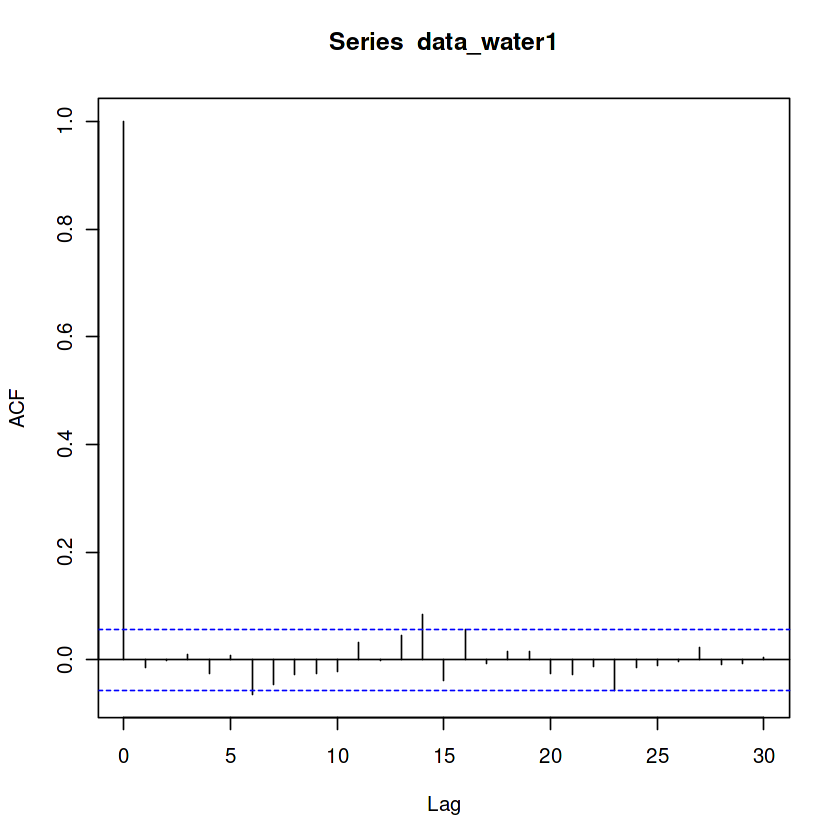

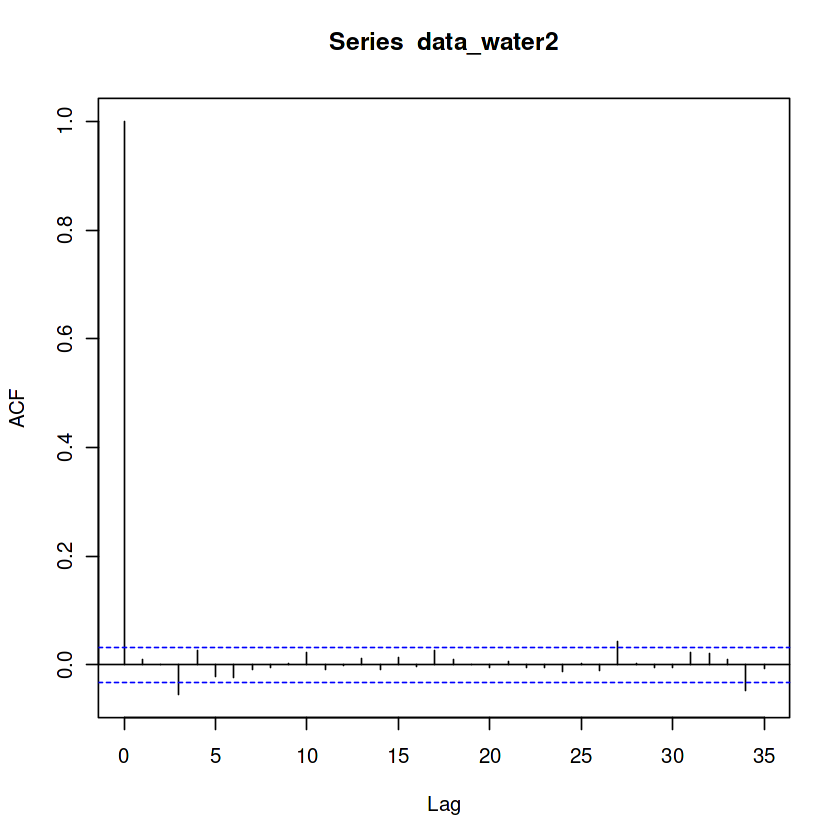

In [108]:
# water 
acf(data_water1)
acf(data_water2)

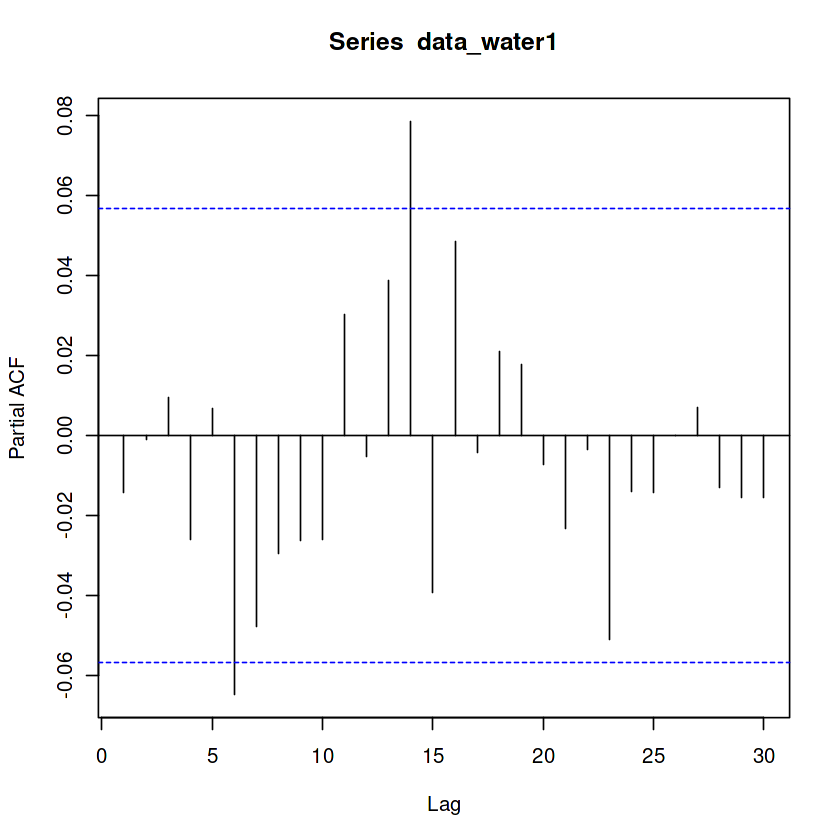

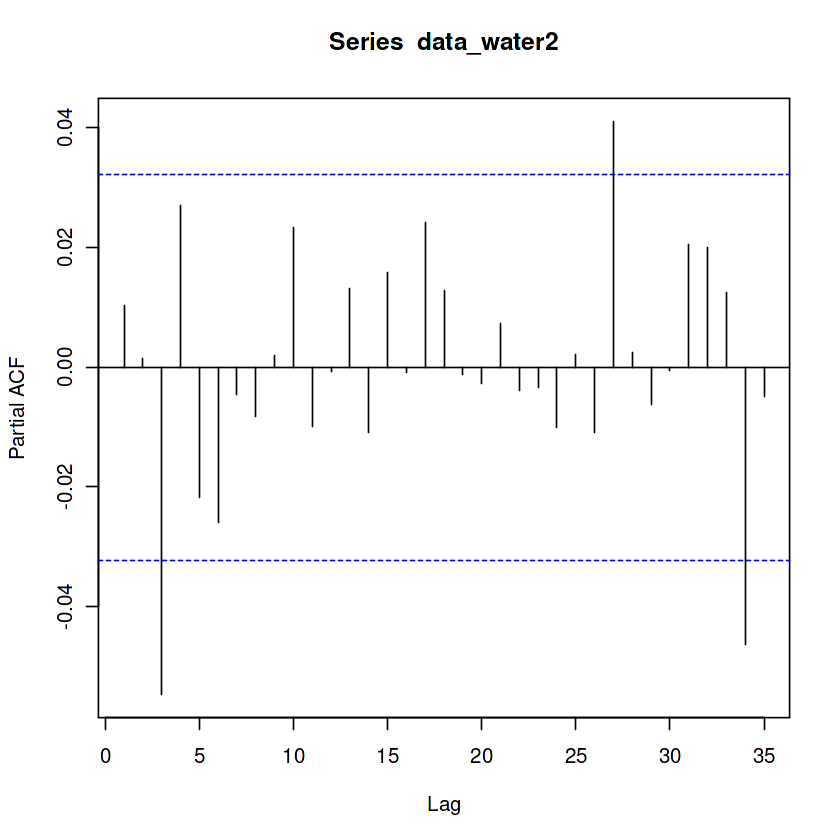

In [109]:
# water 
pacf(data_water1)
pacf(data_water2)

#### water ACF & PACF gives:
- q={0,1,2,3}, (there is a significant spike at 0 in the ACFs but on one occasion a small one at 3 as well so we'll check a few out.)
- p={0} (The PACF seems to be exponnetially decaying and or sinusoidal so we set p=0 )
- d=0 (since we already differentiated by taking the log-returns of the time series)

In [110]:
n_sim <- nrow(simulated_series)
h <- 200  # forecast length
gap_indices_water <- 1198:1248 # indices of the interpolated segment, # 398:448 for guitars, 598:648 for slingshots, 798:848 for stocks, 998:1048 for sugar,  1398:1448 for tranquility
# candidate orders based on ACF/PACF plots
candidate_orders <- list( # excahnge here for candidate orders for each time series
  c(0, 0),
  c(0, 1),
  c(0, 2),
  c(0, 3)
)

In [111]:
results_water <- tibble(
  p = integer(),
  q = integer(),
  AIC = numeric(),
  BIC = numeric(),
  LjungBox_pval = numeric()
)

full_series <- as.numeric(water_train[-1])  
sim_series <- log_return_simulated_water  

# Loop through models
for (order in candidate_orders) {
  p <- order[1]
  q <- order[2]

  for (i in 1:n_sim) {
      # Create a copy of the full training set
      train_copy <- full_series
      #  Replace the interpolated gap with simulated values
      train_copy[gap_indices_water] <- sim_series[i, ]
       #  Convert to time series
      train_ts <- ts(train_copy)
      # Fit ARMA model (ARIMA with d = 0)
      fit <- Arima(train_ts, order = c(p, 0, q))
        # Residual check
      lb_test <- Box.test(residuals(fit), lag = 10, type = "Ljung-Box")
  
      # Store results
      results_water <- add_row(results_water, 
                     p = p,
                     q = q,
                     AIC = AIC(fit),
                     BIC = BIC(fit),
                     LjungBox_pval = lb_test$p.value)
     }
}

      

In [112]:
summary_results_water <- results_water %>%
  group_by(p, q) %>%
  summarise(
    avg_AIC = mean(AIC, na.rm = TRUE),
    avg_BIC = mean(BIC, na.rm = TRUE),
    avg_LB = mean(LjungBox_pval, na.rm = TRUE),
    prop_good_LB = mean(LjungBox_pval > 0.05, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(desc(prop_good_LB), avg_AIC, avg_BIC)


In [113]:
summary_results_water # ARMA(0,3) looks to be preferable

p,q,avg_AIC,avg_BIC,avg_LB,prop_good_LB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,-42535.44,-42502.80,0.4618589,0.986
0,2,-42529.45,-42503.34,0.1138713,0.593
0,1,-42531.11,-42511.53,0.1077483,0.572
0,0,-42529.07,-42516.02,0.0491113,0.332


### Forecast 200 points for the evaluation against the test set (water):

In [131]:
n_sim <- nrow(sim_series)
h <- 200
gap_indices <-  1198:1248 # 398:448 for guitars, 598:648 for slingshots, 798:848 for stocks, 998:1048 for sugar,  1398:1448 for tranquility
#  list for forecasts
ARMA_water_forecasts <- matrix(NA, nrow = n_sim, ncol = h)

for (i in 1:n_sim) {
  # Create copies of the data
  water_copy <- as.numeric(water_train[-1]) # first point is NA so we exclude it
  
  #Replace gaps with simulations
  water_copy[gap_indices] <- sim_series[i, ]
  
  # Fit ARIMA to water and forecast 200 ahead
  water_fit <- Arima(water_copy, order = c(0, 0, 3)) # exchange here for the best model found in the previous step for each time series

  
  # Forecast 200 
  water_fc <- forecast(water_fit, h = h)
  
  # Store forecasts
  ARMA_water_forecasts[i, ] <- water_fc$mean
}

## Water GARCH model:

In [132]:
results_garch_water <- tibble(
  model = character(),
  AIC = numeric(),
  BIC = numeric()
)

garch_orders <- list( c(1,1)) # the vanilla garch
GARCH_water_forecasts <- matrix(NA, nrow = n_sim, ncol = h)

for (model in garch_orders) {
  model_name <- paste0("GARCH(", model[1], ",", model[2], ")")

  spec <- ugarchspec(
    variance.model = list(model = "eGARCH", garchOrder = model), # eGARCH since including the interpolated simulations make the fitting more complex
    mean.model = list(armaOrder = c(0,3), include.mean = TRUE), # for ARMA orders, use the previously found values
    distribution.model = "std" # use student-t dist. for wider tails
  )

  for (i in 1:n_sim) {
    series <- as.numeric(water_train[-1])
    series[gap_indices_water] <- as.numeric(log_return_simulated_water[i, ])
    ts_series <- ts(na.omit(series))

    fit <- ugarchfit(
          spec, 
  data = ts_series,
  solver = "solnp",  # to limit the time for fitting the GARCH models we set these values
  solver.control = list(
    trace = 0,         # suppress output
    maxit = 5,       # reduce max iterations 
    tol = 0.1          # relax tolerance 
  )
)

    water_garch_forecast <- ugarchforecast(fit, n.ahead = 200)
    GARCH_water_forecasts[i, ] <- as.numeric(fitted(water_garch_forecast))


    if (!is.null(fit)) {
      results_garch_water <- add_row(results_garch_water,
                               model = model_name,
                               AIC = infocriteria(fit)[1],
                               BIC = infocriteria(fit)[2])
    }

    #  progress every 50 iterations to see how it goes
    if (i %% 50 == 0) {
      message(sprintf("Completed %d simulations for model %s", i, model_name))
    }
  }
}

        

Completed 50 simulations for model GARCH(1,1)

Completed 100 simulations for model GARCH(1,1)

Completed 150 simulations for model GARCH(1,1)

Completed 200 simulations for model GARCH(1,1)

Completed 250 simulations for model GARCH(1,1)

Completed 300 simulations for model GARCH(1,1)

Completed 350 simulations for model GARCH(1,1)

Completed 400 simulations for model GARCH(1,1)

Completed 450 simulations for model GARCH(1,1)

Completed 500 simulations for model GARCH(1,1)

Completed 550 simulations for model GARCH(1,1)

Completed 600 simulations for model GARCH(1,1)

Completed 650 simulations for model GARCH(1,1)

Completed 700 simulations for model GARCH(1,1)

Completed 750 simulations for model GARCH(1,1)

Completed 800 simulations for model GARCH(1,1)

Completed 850 simulations for model GARCH(1,1)

Completed 900 simulations for model GARCH(1,1)

Completed 950 simulations for model GARCH(1,1)

Completed 1000 simulations for model GARCH(1,1)



In [133]:
summary_garch_water <- results_garch_water %>%
  group_by(model) %>%
  summarise(
    avg_AIC = mean(AIC, na.rm = TRUE),
    avg_BIC = mean(BIC, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange( avg_AIC, avg_BIC)

In [134]:
summary_garch_water

model,avg_AIC,avg_BIC
<chr>,<dbl>,<dbl>
"GARCH(1,1)",-8.348192,-8.33657


# ARIMAX model for time series with a correlated series in the data

## ARIMAX for Gurkor (correlated with Water):  

In [135]:
n_sim <- nrow(sim_series)
h <- 200
gap_indices <- 198:248
gap_indices_water <- 1198:1248
sim_series_water <- log_return_simulated_water
# lists for forecasts
ARIMAX_gurkor_forecasts <- matrix(NA, nrow = n_sim, ncol = h)
ARIMAX_gurkor_aic <- matrix(NA, nrow = n_sim, ncol = 1)
ARIMAX_gurkor_bic <- matrix(NA, nrow = n_sim, ncol = 1)
for (i in 1:n_sim) {
  # Create copies of the data
  gurkor_copy <- as.numeric(gurkor_train[-1])
  water_copy <- as.numeric(water_train[-1])
  
  # Replace gaps with simulations
  gurkor_copy[gap_indices] <- sim_series[i, ]
  water_copy[gap_indices_water] <- sim_series_water[i, ]
  
  #  Fit ARIMA to water and forecast 200 ahead
  water_fit <- Arima(water_copy, order = c(0, 0, 3))
  future_water <- forecast(water_fit, h = h)$mean
  
  #Fit ARIMAX on gurkor with exogenous water
  gurkor_fit <- Arima(gurkor_copy, xreg = water_copy, order = c(0, 0, 2))
  
  # Forecast 200 ahead using future water as xreg
  gurkor_fc <- forecast(gurkor_fit, xreg = future_water, h = h)
  
  #Store forecasts
  ARIMAX_gurkor_forecasts[i, ] <- gurkor_fc$mean

  ARIMAX_gurkor_aic[i] <- AIC(gurkor_fit)
  ARIMAX_gurkor_bic[i] <- BIC(gurkor_fit)
}


## ARIMAX for water just as was done for gurkor:

In [136]:
n_sim <- nrow(sim_series)
h <- 200
gap_indices <- 198:248
gap_indices_water <- 1198:1248
sim_series_water <- log_return_simulated_water
# lists for forecasts
ARIMAX_water_forecasts <- matrix(NA, nrow = n_sim, ncol = h)
ARIMAX_water_aic <- matrix(NA, nrow = n_sim, ncol = 1)
ARIMAX_water_bic <- matrix(NA, nrow = n_sim, ncol = 1)
for (i in 1:n_sim) {
  # Create copies of the data
  gurkor_copy <- as.numeric(gurkor_train[-1])
  water_copy <- as.numeric(water_train[-1])
  
  # Replace gaps with simulations
  gurkor_copy[gap_indices] <- sim_series[i, ]
  water_copy[gap_indices_water] <- sim_series_water[i, ]
  
  #  Fit ARIMA to gurkor and forecast 200 ahead
  gurkor_fit <- Arima(gurkor_copy, order = c(0, 0, 2))
  future_gurkor <- forecast(gurkor_fit, h = h)$mean
  
  #Fit ARIMAX on water with exogenous gurkor
  water_fit <- Arima(water_copy, xreg = gurkor_copy, order = c(0, 0, 3))
      
  # Forecast 200 ahead using future gurkor as xreg
  water_fc <- forecast(water_fit, xreg = future_gurkor, h = h)
  
  #Store forecasts
  ARIMAX_water_forecasts[i, ] <- water_fc$mean

  ARIMAX_water_aic[i] <- AIC(water_fit)
  ARIMAX_water_bic[i] <- BIC(water_fit)
}

# Evaluation of models against the test set

## Gurkor evaluation metrics:

In [137]:
# comparing AIC and BIC for the ARMA and ARIMAX models (GARCH doen't seem to be comparable this way)
b<-mean(ARIMAX_gurkor_aic)
a<-mean(ARIMAX_gurkor_bic)
a
b
summary_results

[1] -43175.63

[1] -43208.27

p,q,avg_AIC,avg_BIC,avg_LB,prop_good_LB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,-41230.72,-41198.08,0.225581786,0.773
0,2,-41231.03,-41204.92,0.167943543,0.694
0,1,-41223.35,-41203.77,0.018755845,0.097
0,0,-41220.89,-41207.83,0.004721117,0.002


In [139]:

mse_list <- list()
mae_list <- list()

forecasts_model1 <- ARMA_gurkor_forecasts     # ARMA
forecasts_model2 <- GARCH_gurkor_forecasts    # GARCH
forecasts_model3 <- ARIMAX_gurkor_forecasts   # ARIMAX 


for (model_num in 1:3) {
  forecasts <- get(paste0("forecasts_model", model_num))  
  
  # Compute error metrics across all 1000 simulations
  mse <- apply(forecasts, 1, function(pred) mean((pred - gurkor_test)^2, na.rm = TRUE))
  mae <- apply(forecasts, 1, function(pred) mean(abs(pred - gurkor_test), na.rm = TRUE))
  
  mse_list[[model_num]] <- mse
  mae_list[[model_num]] <- mae
}

# Summarize results
results <- tibble(
  Model = paste0("Model", 1:3),
  Avg_MSE = sapply(mse_list, mean),
  Avg_MAE = sapply(mae_list, mean),
  SD_MSE = sapply(mse_list, sd),
  SD_MAE = sapply(mae_list, sd)
)

print(results)


# A tibble: 3 × 5
  Model     Avg_MSE Avg_MAE   SD_MSE       SD_MAE
  <chr>       <dbl>   <dbl>    <dbl>        <dbl>
1 Model1 0.00000531 0.00168 4.63e-10 0.0000000475
2 Model2 0.00000544 0.00170 1.57e- 8 0.00000297  
3 Model3 0.00000533 0.00168 1.28e- 9 0.000000126 


The models have very similar, he first model (ARMA) is the simplest so we'll move forward with this one.

## Water evaluation metrics:

In [140]:
# comparing AIC and BIC for the ARMA and ARIMAX models (GARCH doen't seem to be comparable this way)
b<-mean(ARIMAX_water_aic)
a<-mean(ARIMAX_water_bic)
a
b
summary_results_water

[1] -44363.62

[1] -44402.78

p,q,avg_AIC,avg_BIC,avg_LB,prop_good_LB
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,-42535.44,-42502.80,0.4618589,0.986
0,2,-42529.45,-42503.34,0.1138713,0.593
0,1,-42531.11,-42511.53,0.1077483,0.572
0,0,-42529.07,-42516.02,0.0491113,0.332


In [141]:
mse_list <- list()
mae_list <- list()

forecasts_model1 <- ARMA_water_forecasts     # ARMA
forecasts_model2 <- GARCH_water_forecasts    # GARCH
forecasts_model3 <- ARIMAX_water_forecasts   # ARIMAX 


for (model_num in 1:3) {
  forecasts <- get(paste0("forecasts_model", model_num))  
  
  # Compute error metrics across all 1000 simulations
  mse <- apply(forecasts, 1, function(pred) mean((pred - water_test)^2, na.rm = TRUE))
  mae <- apply(forecasts, 1, function(pred) mean(abs(pred - water_test), na.rm = TRUE))
  
  mse_list[[model_num]] <- mse
  mae_list[[model_num]] <- mae
}

# Summarize results
results_water <- tibble(
  Model = paste0("Model", 1:3),
  Avg_MSE = sapply(mse_list, mean),
  Avg_MAE = sapply(mae_list, mean),
      SD_MSE = sapply(mse_list, sd),
  SD_MAE = sapply(mae_list, sd)
)

print(results_water)

# A tibble: 3 × 5
  Model     Avg_MSE Avg_MAE        SD_MSE      SD_MAE
  <chr>       <dbl>   <dbl>         <dbl>       <dbl>
1 Model1 0.00000940 0.00227 0.00000000199 0.000000107
2 Model2 0.00000946 0.00228 0.00000000383 0.000000802
3 Model3 0.00000938 0.00227 0.00000000292 0.000000144


# Forecasting with the adjusted confidence intervals

## Forecasting Gurkor:

In [124]:

h <- 200  # Forecast length
forecasts_matrix <- matrix(NA, nrow = 1000, ncol = h)
arma_forecasts <- vector("list", n_sim)  # Store all forecast objects

for (i in 1:1000) {
  simulated_series <- as.numeric(gurkor_lr)  # full data for forecast
  simulated_series[gap_indices] <- log_return_simulated[i, ]
  ts_data <- ts(simulated_series)
  
  # Fit your chosen model
  fit <- Arima(ts_data, order = c(0, 0, 2))  
  
  # Forecast h=200 steps ahead
  fcast <- forecast(fit, h = h)
  
  forecasts_matrix[i, ] <- as.numeric(fcast$mean)
    arma_forecasts[[i]] <- fcast  # Save forecast object
}



In [125]:
z95 <- qnorm(0.975)
h <- 200

all_upper <- matrix(NA, nrow = n_sim, ncol = h)
all_lower <- matrix(NA, nrow = n_sim, ncol = h)
all_mean  <- matrix(NA, nrow = n_sim, ncol = h)

for (i in 1:n_sim) {
  f <- arma_forecasts[[i]]
    se<-(as.numeric(f$upper[,2]) - as.numeric(f$mean)) / as.numeric(z95)
  
  
  all_mean[i, ]  <- as.numeric(f$mean)
  all_upper[i, ] <- as.numeric(f$mean) + z95 * se
  all_lower[i, ] <- as.numeric(f$mean) - z95 * se
}


In [126]:
# Combine across simulations
mean_curve  <- colMeans(all_mean)
lower_bound <- apply(all_lower, 2, quantile, 0.025)
upper_bound <- apply(all_upper, 2, quantile, 0.975)


In [127]:
gurkor<-data[,3]
gurkor <- gurkor[1:(length(gurkor) - 200)]
last_price <- tail(na.omit(gurkor), 1)

mean_price  <- last_price * exp(cumsum(mean_curve))
lower_price <- last_price * exp(cumsum(lower_bound))
upper_price <- last_price * exp(cumsum(upper_bound))


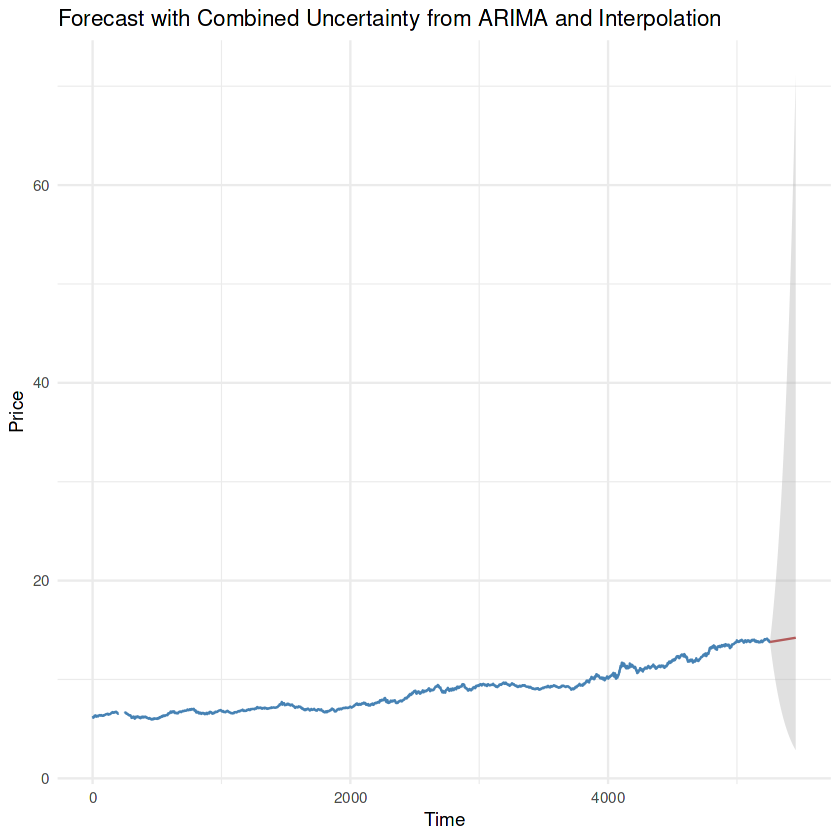

In [128]:
df_plot <- data.frame(
  Time  = (length(gurkor) + 1):(length(gurkor) + h),
  Mean  = mean_price,
  Lower = lower_price,
  Upper = upper_price
)

ggplot() +
  geom_line(aes(x = seq_along(gurkor), y = gurkor),
            color = "steelblue") +
  geom_line(data = df_plot, aes(x = Time, y = Mean),
            color = "firebrick") +
  geom_ribbon(data = df_plot, aes(x = Time, ymin = Lower, ymax = Upper),
              fill = "gray70", alpha = 0.4) +
  labs(title = "Forecast with Combined Uncertainty from ARIMA and Interpolation",
       x = "Time", y = "Price") +
  theme_minimal()


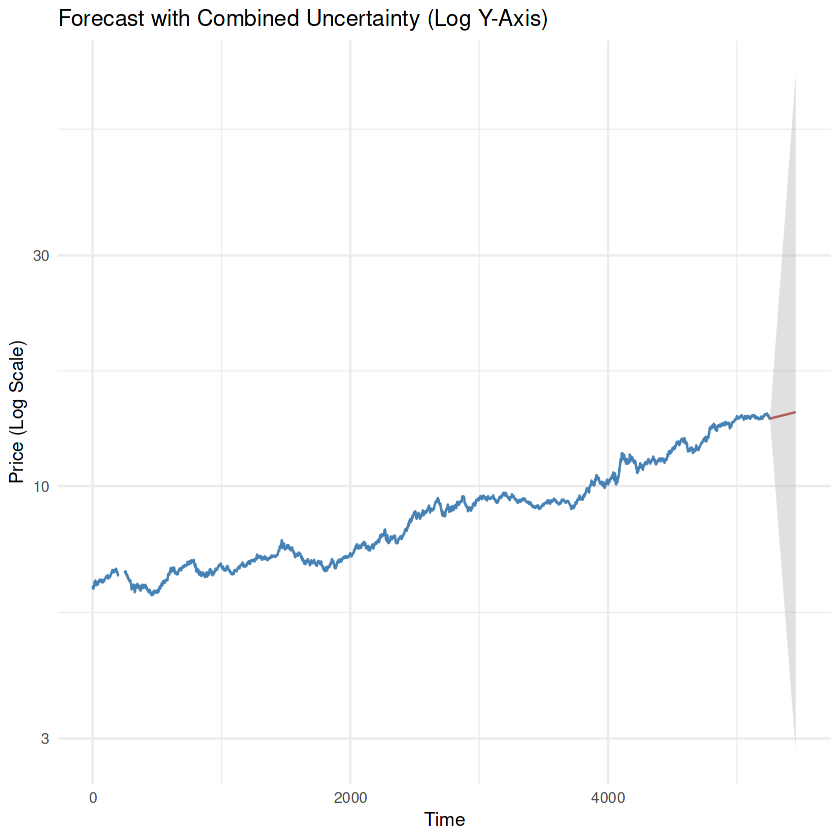

In [129]:
ggplot() +
  geom_line(aes(x = seq_along(gurkor), y = gurkor),
            color = "steelblue") +
  geom_line(data = df_plot, aes(x = Time, y = Mean),
            color = "firebrick") +
  geom_ribbon(data = df_plot, aes(x = Time, ymin = Lower, ymax = Upper),
              fill = "gray70", alpha = 0.4) +
  scale_y_log10() +
  labs(title = "Forecast with Combined Uncertainty (Log Y-Axis)",
       x = "Time", y = "Price (Log Scale)") +
  theme_minimal()


In [130]:
# Create pdf for report
pdf("forecast_plot.pdf", width = 8, height = 5)  

# Plot
ggplot() +
  geom_line(aes(x = seq_along(gurkor), y = gurkor),
            color = "steelblue") +
  geom_line(data = df_plot, aes(x = Time, y = Mean),
            color = "firebrick") +
  geom_ribbon(data = df_plot, aes(x = Time, ymin = Lower, ymax = Upper),
              fill = "gray70", alpha = 0.4) +
  scale_y_log10() +
  labs(title = "Forecast with Combined Uncertainty (Log Y-Axis)",
       x = "Time", y = "Price (Log Scale)") +
  theme_minimal()



dev.off()


png 
  2

## Forecasting Water:

In [142]:
h <- 200  # Forecast length
forecasts_matrix_water <- matrix(NA, nrow = 1000, ncol = h)
arma_forecasts_water <- vector("list", n_sim)  # Store all forecast objects

for (i in 1:1000) {
  simulated_series <- as.numeric(water_lr)  # full data for forecast
  simulated_series[gap_indices_water] <- log_return_simulated_water[i, ]
  ts_data <- ts(simulated_series)
  
  # Fit your chosen model
  fit <- Arima(ts_data, order = c(0, 0, 3))  
  
  # Forecast h=200 steps ahead
  fcast <- forecast(fit, h = h)
  
  forecasts_matrix_water[i, ] <- as.numeric(fcast$mean)
    arma_forecasts_water[[i]] <- fcast  # Save forecast object
}


In [143]:
z95 <- qnorm(0.975)
h <- 200

all_upper_water <- matrix(NA, nrow = n_sim, ncol = h)
all_lower_water <- matrix(NA, nrow = n_sim, ncol = h)
all_mean_water  <- matrix(NA, nrow = n_sim, ncol = h)

for (i in 1:n_sim) {
  f <- arma_forecasts_water[[i]]
    se<-(as.numeric(f$upper[,2]) - as.numeric(f$mean)) / as.numeric(z95)
  
  
  all_mean_water[i, ]  <- as.numeric(f$mean)
  all_upper_water[i, ] <- as.numeric(f$mean) + z95 * se
  all_lower_water[i, ] <- as.numeric(f$mean) - z95 * se
}


In [144]:
# Combine across simulations
mean_curve_water  <- colMeans(all_mean_water)
lower_bound_water <- apply(all_lower_water, 2, quantile, 0.025)
upper_bound_water <- apply(all_upper_water, 2, quantile, 0.975)

In [146]:
water<-data[,8]
water <- water[1:(length(water) - 200)]
last_price_water <- tail(na.omit(water), 1)

mean_price_water  <- last_price_water * exp(cumsum(mean_curve_water))
lower_price_water <- last_price_water * exp(cumsum(lower_bound_water))
upper_price_water <- last_price_water * exp(cumsum(upper_bound_water))

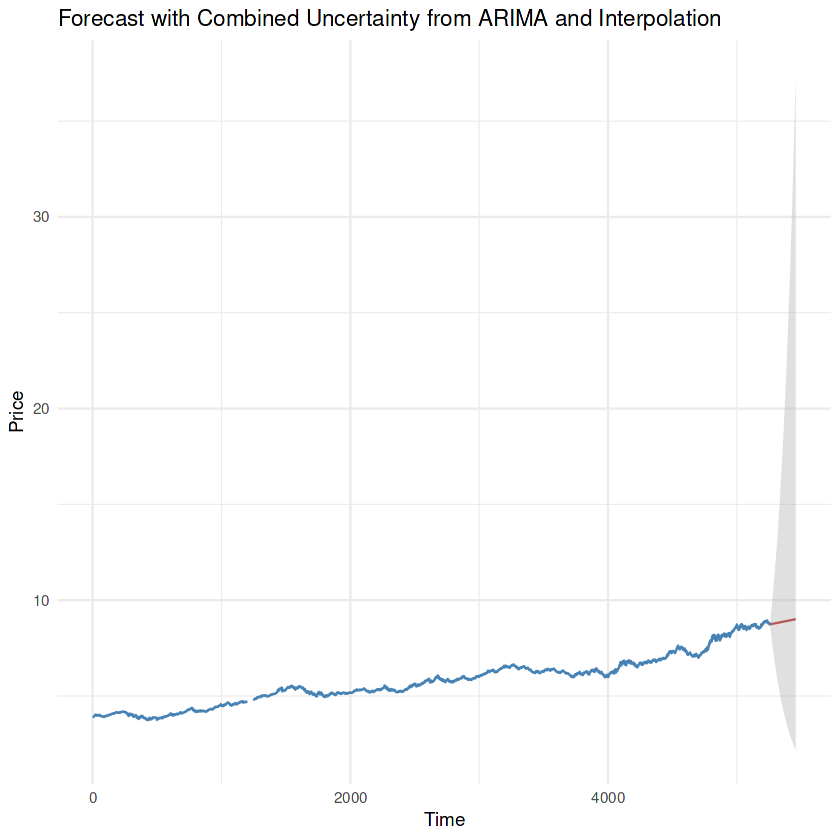

In [147]:
df_plot_water <- data.frame(
  Time  = (length(water) + 1):(length(water) + h),
  Mean  = mean_price_water,
  Lower = lower_price_water,
  Upper = upper_price_water
)

ggplot() +
  geom_line(aes(x = seq_along(water), y = water),
            color = "steelblue") +
  geom_line(data = df_plot_water, aes(x = Time, y = Mean),
            color = "firebrick") +
  geom_ribbon(data = df_plot_water, aes(x = Time, ymin = Lower, ymax = Upper),
              fill = "gray70", alpha = 0.4) +
  labs(title = "Forecast with Combined Uncertainty from ARIMA and Interpolation",
       x = "Time", y = "Price") +
  theme_minimal()

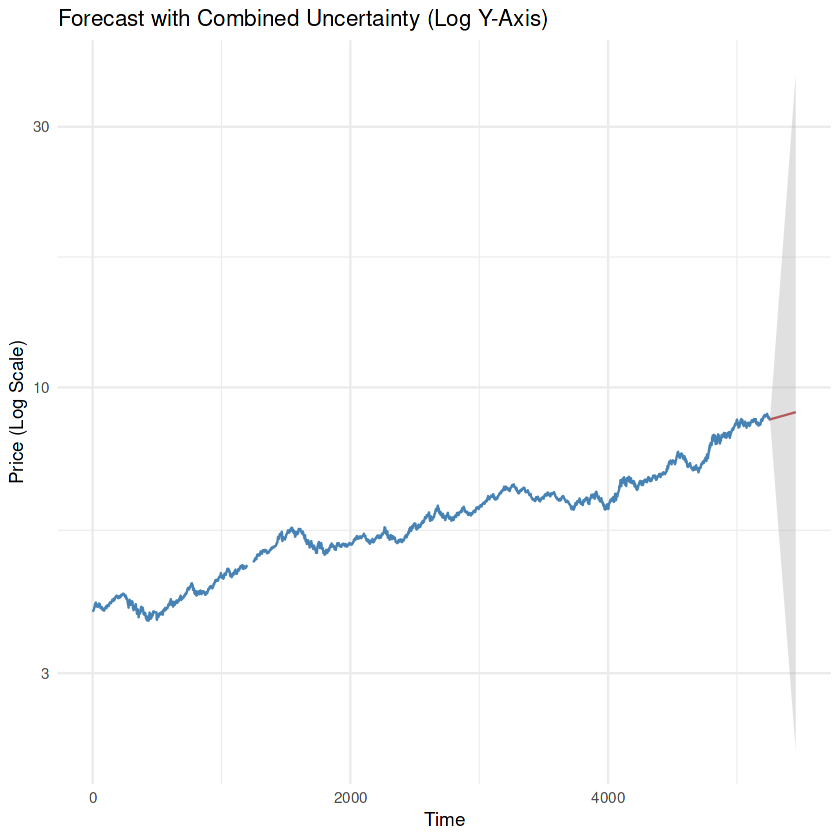

In [148]:
ggplot() +
  geom_line(aes(x = seq_along(water), y = water),
            color = "steelblue") +
  geom_line(data = df_plot_water, aes(x = Time, y = Mean),
            color = "firebrick") +
  geom_ribbon(data = df_plot_water, aes(x = Time, ymin = Lower, ymax = Upper),
              fill = "gray70", alpha = 0.4) +
  scale_y_log10() +
  labs(title = "Forecast with Combined Uncertainty (Log Y-Axis)",
       x = "Time", y = "Price (Log Scale)") +
  theme_minimal()